# ImageAutoDecoder

This notebook is concerned with *Part 2* of the assignment.

This is: 
+ Autoencoding and clustering image representations.

## Main Code

### Preliminaries

In [1]:
# Any installs
! pip install cowsay 

Defaulting to user installation because normal site-packages is not writeable


In [13]:
# Declare Imports
import os, sys, json
# import tabulate
import pandas as pd
pd.set_option('display.max_columns', None)

In [14]:
# Create some relevant folders for data persistence
sys.path.append('..')
# os.makedirs("../../etl/data/processed/TestSGF1", exist_ok=True)

In [15]:
# CONFIGURATIONS
trainingdir = "/scratch/lt2326-2926-h24/wikiart/train"
testingdir = "/scratch/lt2326-2926-h24/wikiart/train"
device = "cuda:0"

BATCHED = True

In [16]:
# Reload modules (uncomment when actively editing an imported module 
# w.o. needing to restart kernel)
from importlib import reload
import wikiart
reload(wikiart)
from wikiart import WikiArtDataset

# LOAD DATASET
traindataset = WikiArtDataset(trainingdir, device)

# LOAD TEST DATASET
testdataset = WikiArtDataset(testingdir, device)

Gathering files for /scratch/lt2326-2926-h24/wikiart/train
...............................finished
Gathering files for /scratch/lt2326-2926-h24/wikiart/train
...............................finished


In [17]:
weights = traindataset.get_balancing_weights()
weights[2400]

{'Action_painting': 0, 'Abstract_Expressionism': 0, 'Early_Renaissance': 0, 'Art_Nouveau_Modern': 0, 'Analytical_Cubism': 0, 'Naive_Art_Primitivism': 0, 'High_Renaissance': 0, 'Synthetic_Cubism': 0, 'Mannerism_Late_Renaissance': 0, 'Romanticism': 0, 'Pop_Art': 0, 'New_Realism': 0, 'Minimalism': 0, 'Post_Impressionism': 0, 'Impressionism': 0, 'Symbolism': 0, 'Rococo': 0, 'Fauvism': 0, 'Color_Field_Painting': 0, 'Baroque': 0, 'Contemporary_Realism': 0, 'Expressionism': 0, 'Pointillism': 0, 'Northern_Renaissance': 0, 'Realism': 0, 'Cubism': 0, 'Ukiyo_e': 0}
{'Action_painting': 18, 'Abstract_Expressionism': 449, 'Early_Renaissance': 246, 'Art_Nouveau_Modern': 688, 'Analytical_Cubism': 15, 'Naive_Art_Primitivism': 373, 'High_Renaissance': 198, 'Synthetic_Cubism': 38, 'Mannerism_Late_Renaissance': 246, 'Romanticism': 1157, 'Pop_Art': 244, 'New_Realism': 41, 'Minimalism': 212, 'Post_Impressionism': 946, 'Impressionism': 2269, 'Symbolism': 679, 'Rococo': 369, 'Fauvism': 163, 'Color_Field_Paint

62.971698113207545

In [ ]:
import torch

weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     

train_loader_balanced = torch.utils.data.DataLoader(
    traindataset, 
    batch_size = 32,
    sampler = sampler, 
) 

test_loader = torch.utils.data.DataLoader(
    testdataset,
    batch_size=32,
    shuffle=True,
)

In [ ]:
from itertools import islice

# Verifying that the data 
lbl_idx = [x[1] for x in islice(train_loader_balanced, 100)]

In [20]:
import numpy as np
np.histogram(lbl_idx)

(array([356, 333, 261, 357, 232, 375, 353, 245, 328, 360]),
 array([ 0. ,  2.6,  5.2,  7.8, 10.4, 13. , 15.6, 18.2, 20.8, 23.4, 26. ]))

In [ ]:
# Clear GPU cache and garbage collector stuff
import gc
gc.collect()
torch.cuda.empty_cache()

## AutoEncoder

In [21]:
import torch
from torch import nn, Tensor
from typing import Tuple
from torch.optim import lr_scheduler

### AutoEncoder 1

In [54]:
class Encoder(nn.Module):
    """
    The Encoder network. 
    A deep neural network that learns a lower-dimensional representation of the input data by mapping it into an embedding.
    We specify the architecture of the encoder with the hidden_sizes parameter.
    """
    def __init__(self, input_size: int, 
                hidden_layers: Tuple[int] = [500, 500, 2000, 10],
                dropout_rate: float=0.2,
                activation=nn.ReLU()
                ):
        super().__init__()
        
        # First layer, the input layer
        self.input_layer = torch.nn.Linear(input_size, hidden_layers[0])
        self.n_layers = 0
        for i in range(0, len(hidden_layers) -1):
          setattr(self, f"dense_{i}", torch.nn.Linear(hidden_layers[i], hidden_layers[i+1]))
          self.n_layers += 1
        
        self.activation = activation
        self.hidden_layers= hidden_layers
        
        # Add dropout to prevent overfitting
        self.dropout  = nn.Dropout(dropout_rate)
        self.dropout_rate = dropout_rate
        self.input_size = input_size

    def forward(self, x: Tensor) -> Tensor:
      # Special treatment for input layer
      x = self.activation(self.input_layer(x)) # Apply all hidden layers (layers in the "middle")
      for i in range(0, self.n_layers -1):
        dense_i = getattr(self, f"dense_{i}")
        x = self.activation(dense_i(x))
        x = self.dropout(x)
          
      # Last layer without activation function to output embedding
      output_layer = getattr(self, f"dense_{self.n_layers-1}")
      return output_layer(x)

In [16]:
class Decoder(nn.Module):
    """
    Same as the encoder, but the layers are in reverse order. 
    So, we pass the encoder as input and use its hidden_sizes to specify 
    the decoder network.
    """
    def __init__(self,
                 encoder,
                 activation=nn.ReLU()
                ):
        super().__init__()
        # self.layers = encoder.layers
        self.n_layers = encoder.n_layers
        
        ########################################################
        ### Reverse the order of the layers from the encoder ###
        self.hidden_layers= encoder.hidden_layers[::-1]
        
        # Add layers to the network     
        for i in range(0, self.n_layers):
            setattr(self, f"dense_{i}", torch.nn.Linear(self.hidden_layers[i],
                                                        self.hidden_layers[i+1])
                   )
        # Specify output layer separately (same as input layer of the encoder)
        self.output_layer = torch.nn.Linear(self.hidden_layers[-1],
                                                        encoder.input_size)
        
        self.activation = activation
        self.dropout  = nn.Dropout(encoder.dropout_rate)
    def forward(self, x:Tensor) -> Tensor:
        for i in range(0, self.n_layers):
            dense_i = getattr(self, f"dense_{i}")
            x = dense_i(x)
            x = self.activation(x)
            x = self.dropout(x)
        return self.output_layer(x)

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size: int, 
                hidden_layers: Tuple[int] = [500, 500, 2000, 10],
                dropout_rate: float=0.2 # Used to prevent overfitting
            ):
        super().__init__()
        self.encoder = Encoder(input_size, hidden_layers, dropout_rate)
        # Decoder is based on the encoder architecture
        self.decoder = Decoder(self.encoder)
        # Defines the structure of our network
        self.hidden_layers = hidden_layers
    def forward(self, x: Tensor) -> Tuple[Tensor]:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
# Learning Rate
lr = 0.1

n_input_features = 784
# Initialize architecture of our Auto-Encoder
model = AutoEncoder(input_size=n_input_features, 
                    hidden_layers=[
                                500, 
                                500, 
                                2000, 
                                10 # This is the dimension of the embedding
                                 ],
                   # Prevent overfitting by deactivating 20% of the neurons during training
                    dropout_rate=0.2 
                   ).to(device)
# Use Stochastic Gradient Descent as optimizer with momentum 0.9
optimizer = torch.optim.SGD(lr=lr, 
                            momentum=0.9,
                            params=model.parameters())

### AutoEncoder 2

In [22]:
import torch.nn as nn

class Flatten(torch.nn.Module):
    def forward(self, x):
        # print("Test, test, test")
        # batch_size = x.shape[0] * x.shape[1] * x.shape[2]
        # print("Shapes", x.shape[0], x.shape[1], x.shape[2])
        # ret = x.view(batch_size, 1)
        ret = x.view(x.size(0), -1)
        # print("Ret shape", ret.shape)
        return ret

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3 , 3*3, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(9,16,kernel_size=5),
            nn.ReLU(True),
            Flatten(),
            nn.Linear(16 * 408 * 408, 32)
            )
        self.decoder = nn.Sequential( 
            nn.Linear(32, 16 * 408 * 408),
            nn.Unflatten(1, [16, 408, 408]),
            nn.ConvTranspose2d(16,9,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(9,3,kernel_size=5),
            nn.ReLU(True))
    def forward(self, x):
        x = self.encoder(x)
        # print("Encoding success!")
        x = self.decoder(x)
        return x

### Model, Loss and Optimiser instantiation

In [23]:
# Learning Rate
LEARNING_RATE = 0.1

model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Activate training mode
model.train()

# Use MSE as loss function
# We use the Mean Squared Error as the reconstruction loss.
loss_ = nn.MSELoss()

# Use learning rate decay - reduce learning rate as training continues
scheduler = lr_scheduler.StepLR(optimizer, 
                                  step_size=100,
                                  gamma=0.1)

In [24]:
from tqdm.notebook import tqdm
# import numpy as np

### TRAINING ###
n_epochs = 5
eval_every = 10
best_loss = np.infty

with tqdm(total=n_epochs) as pbar:
    for epoch in range(n_epochs):
        losses = []
        # Iterate over data in batches
        for x_batch, y_batch in tqdm(train_loader_balanced, leave=False):
            # PyTorch specific; We need to reset all gradients
            optimizer.zero_grad()
            
            # 0. Transform input batch data from 28 X 28 to 784 features
            #   Note that our encoder maps the data into just 10 features!
            x_batch = x_batch.to(device)
            # x_batch = x_batch.view(x_batch.shape[0], -1)
            # x_batch = x_batch[0]
            # print(x_batch.shape)
            
            # 1. Apply AutoEncoder model (forward pass).
            #    We use the output of the decoder for training.
            output = model(x_batch)[1]
            
            # 2. Calculate the reconstruction loss
            loss = loss_(output, x_batch)
            losses.append(loss.item())
            
            # 3. Backpropagate the loss
            loss.backward()
            
            # 4. Update the weights
            optimizer.step()
        
        # Mean loss of the batches in this epoch
        mean_loss = np.round(np.mean(losses),
                            5)
        
        # Print current loss after 'eval_every' epochs
        if (epoch+1) % eval_every == 0:
            print(f"Loss at epoch [{epoch+1} / {n_epochs}]: {mean_loss}")

        # Update learning rate as training continues
        scheduler.step()

        # Progress bar
        pbar.write('processed: %d' %epoch)
        pbar.update(1)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

/usr/local/lib64/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 3, 416, 416])) that is different to the input size (torch.Size([3, 416, 416])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

## Clustering

In [25]:
# Obtain the embeddings for each image
def extract_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for data in islice(data_loader, 30):
            inputs = data[0].to(device)
            encoded = model.encoder(inputs)
            # print("Detaching")
            encoded = encoded.cpu().detach()
            embeddings.append(encoded)
    return torch.vstack(embeddings)

embeddings = extract_embeddings(model, test_loader)

In [26]:
embeddings

# embeddings[2].shape

# embeddings[0].view(-1, 16*408*408).shape

tensor([[-1.3621e+07,  2.3963e+08,  1.1258e+08,  ...,  3.3763e+08,
          1.7416e+08,  1.4807e+08],
        [ 4.0505e+06,  3.7394e+07,  2.7175e+07,  ...,  6.8456e+07,
          2.5417e+07,  2.0646e+07],
        [ 2.2257e+06,  1.5345e+08,  8.9151e+07,  ...,  2.4422e+08,
          1.0840e+08,  9.0437e+07],
        ...,
        [ 8.4766e+06,  1.8502e+08,  1.1656e+08,  ...,  3.0934e+08,
          1.2898e+08,  1.0663e+08],
        [-5.3743e+07,  1.7610e+08,  1.4639e+07,  ...,  1.3660e+08,
          1.4060e+08,  1.2642e+08],
        [-1.8868e+07,  1.2356e+08,  3.9639e+07,  ...,  1.4391e+08,
          9.3185e+07,  8.1062e+07]])

In [27]:
# As clustering method we will 
# employ K-Means
from sklearn.cluster import KMeans

def get_label_numbers(data_loader):
    nested_y = []
    for dp in islice(data_loader, 30):
        nested_y.append(dp[1])
    return [int(label) for batch in nested_y for label in batch]

labels = get_label_numbers(test_loader)

In [28]:
# We know K apriori in the supervised setting
kmeans = KMeans(n_clusters=len(set(labels)), random_state=42).fit(embeddings.numpy())
clusters = kmeans.labels_

In [29]:
# We cluster using the high-dimensional representations
clusters


array([22,  3,  7,  5, 18,  8,  0, 15, 19,  9, 12, 17, 21,  1,  3, 21, 12,
       10,  7, 12,  1,  7, 10,  4,  2, 16,  1, 15,  1,  7, 14, 18, 19, 22,
       22, 10,  5, 19,  3, 11, 13, 18, 19,  1, 15, 12, 13, 19,  6, 13,  5,
        3,  0, 18, 13,  7, 17, 17,  8,  2,  1, 21, 15, 12,  5,  0, 12, 16,
       12, 16,  1,  1,  4, 22,  0, 21,  6, 15,  7, 21, 12,  4,  2, 23, 11,
        3,  3, 12, 13, 23, 22,  3,  9,  2,  2,  5, 18, 15,  2, 16, 23, 21,
       13, 12, 17, 20,  9,  0, 17, 12,  1, 11,  6, 11, 19, 22,  4, 16,  4,
        2,  5, 18,  9,  4, 12, 15, 10, 21, 19, 16,  2,  7,  1, 21,  4,  4,
        4, 12,  0, 16, 12, 11,  1, 16,  4,  7, 20, 15, 14, 20, 13, 16, 11,
       10,  0,  7, 13,  1,  7,  5,  0, 10, 19,  4,  4,  9, 13,  7,  7, 19,
        7, 19, 18,  5,  3,  3, 11, 22, 21, 17, 21, 23,  7, 10, 12, 21, 21,
       14, 23, 23,  4,  2, 19, 21, 11,  1, 17,  5,  3,  8, 12,  8, 11,  1,
       10,  4,  9, 14, 12, 11, 18, 12,  6,  7, 16,  2, 18, 19, 12, 23, 19,
        1,  7, 15,  0,  4

## Dimensionality Reduction

### PCA / (UMAP?)

In [30]:
# For clustering we use PCA, because
# because it is implemented in sci-kit learn.
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings_red = pca.fit_transform(embeddings)

# A further interesting DR method is UMAP
# but it is not available out-of-the-box in scikit
# learn.

In [31]:
embeddings_red

array([[ 3.65296941e+08,  1.07543450e+08],
       [-8.31501045e+08, -5.39377010e+07],
       [-8.27434770e+07, -4.95921594e+06],
       ...,
       [ 1.71175037e+08, -2.72937179e+07],
       [-3.48901440e+08,  2.96226736e+08],
       [-4.35632472e+08,  9.53746130e+07]])

### Visualisation

#### Plotting

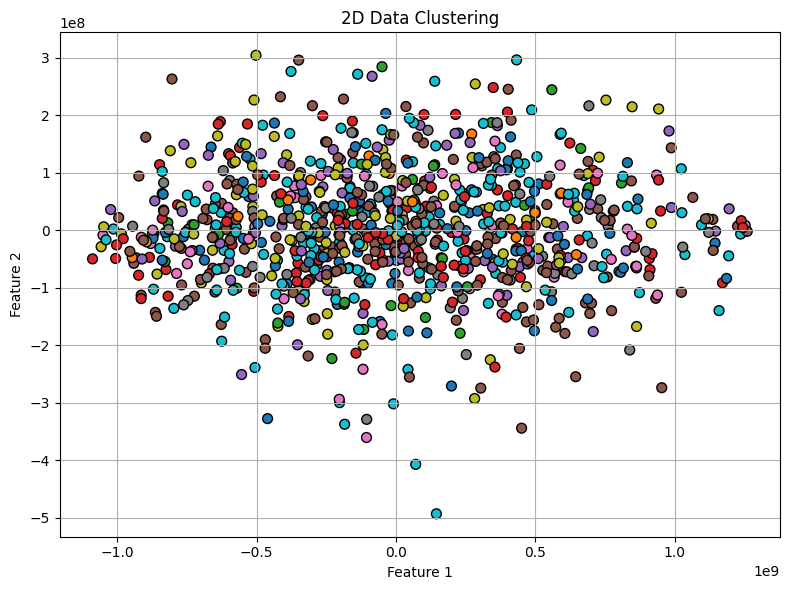

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_clusters_2d(data_points, labels, title="2D Data Clustering", cmap="tab10"):
    """
    Visualizes 2D data points clustered by labels.

    Parameters:
        data_points (array-like): A 2D array or list of shape (n_samples, 2).
        labels (array-like): A list or array of labels corresponding to each point.
        title (str): Title of the plot (default: "2D Data Clustering").
        cmap (str): Matplotlib colormap for distinguishing clusters (default: "tab10").
    """
    # Convert inputs to NumPy arrays for compatibility
    data_points = np.array(data_points)
    labels = np.array(labels)
    
    # Ensure data points are 2D
    if data_points.shape[1] != 2:
        raise ValueError("data_points must have exactly two dimensions (n_samples, 2).")
    
    # Plot the clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        data_points[:, 0], data_points[:, 1], c=labels, cmap=cmap, s=50, edgecolor='k'
    )
    
    # Add a legend for the clusters
    legend1 = plt.legend(
        *scatter.legend_elements(), title="Clusters", loc="upper right", bbox_to_anchor=(1.15, 1)
    )
    plt.gca().add_artist(legend1)
    
    # Set plot labels and title
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
#data = np.random.rand(100, 2)  # 100 random 2D points
#labels = np.random.randint(0, 4, 100)  # Random cluster labels (0, 1, 2, or 3)
plot_clusters_2d(embeddings_red, labels)

## Any final remarks
- Either in MD or in code (like below)